# AGU Combined Analysis

In [1]:
import os
import subprocess
import sys
# import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from PIL import Image 
import pandas as pd
import sqlite3
from IPython.display import IFrame

from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
from SALib.test_functions import Ishigami
import numpy as np
import seaborn as sns

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
print(gisbase)

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs

# Import GRASS Jupyter
import grass.jupyter as gj

/usr/local/grass85


In [205]:
class RasterStats:
    def __init__(self, univar):
        for key, value in univar.items():
            setattr(self, key, value)


class Site:
    mapset = 'PERMANENT'
    scalars = [0.25, 0.5, 1, 2, 4]
    resolutions = [1, 3, 5, 10, 30]
    
    # 1st Order Togographic Derivative
    elevation = "elevation"


    hillshade = "hillshade@basic"

    # 2nd Order Topographic Derivatives
    slope = "slope@basic"
    aspect = "aspect@basic"
    pcurv = "pcurv@basic"
    tcurv = "tcurv@basic"

    # Terrain Morphology
    geomorphons = "geomorphons"

    # Terrain Ruggedness Index
    tri = "tri"
    ars = None

    # Stats
    univar = {}

    def __init__(self, site):
        self.naip_year = site['naip']
        self.site = site['site']
        self.epsg = site['crs']
        self.resolution = site['res']
        self.ortho = f"naip_{self.naip_year}_rgb@naip"
        self.ndvi = f"naip_{self.naip_year}_ndvi@basic"

        self._start_grass_session()

    def _start_grass_session(self):
        gisdb = os.path.join(os.getenv('HOME'), 'grassdata')
        gj.init(gisdb, self.site, self.mapset)
        gs.run_command("g.region", flags='a', res=self.resolution, raster=self.elevation)

    def __str__(self):
        return f"Site: {self.site}, CRS: {self.epsg}, Resolution: {self.resolution}m, NAIP: {self.naip_year}"
    

    def univar_stats(self, input_map):
        """Get raster statistics"""
        # if self.univar.get(input_map):
        #     return self.univar[input_map]
        
        json_data = gs.parse_command('r.univar', map=input_map, flags='e', format='json')

        self.univar[input_map] = RasterStats(json_data[0])

        return self.univar[input_map]
    
    def area(self, unit='m2'):
        """Calculate area of site"""

        resolution = float(self.resolution)

        if unit == 'm2':
            return (self.univar_stats(self.elevation).n * resolution**2)
        if unit == 'km2':
            return (self.univar_stats(self.elevation).n * resolution**2) / 1e6
        if unit == 'acres':
            return (self.univar_stats(self.elevation).n * resolution**2) / 4046.86
        return None
    
    def area_ruggedness_scale(self):
        """Calculate area ruggedness scale"""
        # if self.ars:
        #     return self.ars
        
        gs.run_command("r.tri", input=self.elevation, output=self.tri, size=5, processes=6, overwrite=True)
        json_data = gs.parse_command('r.univar', map=self.tri, flags='e', format='json')
        self.ars = json_data[0]['mean']
        return self.ars
    
    def fetch_sensitivity_analysis(self, mapset):
        """Fetch sensitivity analysis results"""
        # file_location = os.path.join("../output", self.site, mapset, 'metadata_analysis_1.csv')
        file_location = os.path.join("../output", self.site, mapset, 'metadata_depth_analysis_1.csv')
        # file_location = os.path.join("../output", self.site, mapset, 'sensitivity_analysis_1.csv')
        
        print(file_location)
        if os.path.isfile(file_location):
            df = pd.read_csv(file_location)
            return df
        
        return None
    

    
output_dir = os.path.join("..", "output", "agu2024")

In [210]:
SITE_PARAMS = [
    {"site": "clay-center", "crs": "32614", "res": "3", "naip": 2021},
    # {"site": "coweeta", "crs": "26917", "res": "10", "naip": 2022},
    # {"site": "SFREC", "crs": "26910", "res": "1", "naip": 2022},
    {"site": "SJER", "crs": "26911", "res": "1", "naip": 2022},
    # {"site": "tx069-playas", "crs": "32613", "res": "8", "naip": 2022},
]

def combine_dataframe():
    combine_df = []
    sensitivity_mapset = 'sensitivity_1'
    for site_param in SITE_PARAMS:
        print(f"{'#' * 50}\n")
        site = Site(site_param)
        print(site)
        univar = site.univar_stats("elevation")
        print(f"""
              Area (km2): {site.area(unit='km2')}
              n: {univar.n}
              Cells: {univar.cells}
              Min: {univar.min} Max: {univar.max}
              Range: {univar.range}
              Mean: {univar.mean}
              Median: {univar.median}
              Std: {univar.stddev}
        """)
        ars = site.area_ruggedness_scale()
        print(f"ARS: {ars}")
        df = site.fetch_sensitivity_analysis(sensitivity_mapset)
        df['site_name'] = site.site
        df['std'] = univar.stddev
        # df['ars'] = ars
        if df is not None:
            combine_df.append(df)
        #     print(df.count())
            # print(df.groupby(by="resolution").head())
        results = pd.concat(combine_df)
        
    return results

results_df = combine_dataframe()
    # df_metadata.to_csv(os.path.join("../output", site, mapset, 'metadata_analysis_1.csv'))


##################################################

Site: clay-center, CRS: 32614, Resolution: 3m, NAIP: 2021

              Area (km2): 1.532196
              n: 170244
              Cells: 178480
              Min: 376.6749572753906 Max: 396.57293701171875
              Range: 19.897979736328125
              Mean: 386.71769501379185
              Median: 386.3173828125
              Std: 5.032406006553623
        
ARS: 0.13453399631105287
../output/clay-center/sensitivity_1/metadata_depth_analysis_1.csv
##################################################

Site: SJER, CRS: 26911, Resolution: 1m, NAIP: 2022

              Area (km2): 0.295126
              n: 295126
              Cells: 701111
              Min: 333.11639404296875 Max: 371.12286376953125
              Range: 38.0064697265625
              Mean: 349.67217957706487
              Median: 349.1444091796875
              Std: 7.959113607336838
        
ARS: 0.1405341076562333
../output/SJER/sensitivity_1/metadata_depth_anal

In [208]:
results_df.head()

,Unnamed: 0,n,null_cells,cells,min,max,range,mean,mean_of_abs,stddev,...,resolution,scalar,minute,stat_type,ars,error,run_id,normalized_error,p_density,std
0,0,1519531,81705,1601236,0.000249,0.419628,0.419379,0.009996,0.009996,0.017578,...,1,25,5,average,0.045138,0.00162,1_025,2.0,0.238033,5.032406
1,1,1519531,81705,1601236,0.000249,0.511255,0.511006,0.012634,0.012634,0.029195,...,1,25,10,average,0.045138,0.00162,1_025,2.0,0.238033,5.032406
2,2,1519531,81705,1601236,0.000249,0.683369,0.683120,0.014871,0.014871,0.037732,...,1,25,15,average,0.045138,0.00162,1_025,2.0,0.238033,5.032406
3,3,1519531,81705,1601236,0.000249,0.896783,0.896534,0.016880,0.016880,0.044842,...,1,25,20,average,0.045138,0.00162,1_025,2.0,0.238033,5.032406
4,4,1519531,81705,1601236,0.000249,1.124780,1.124530,0.018729,0.018729,0.051112,...,1,25,25,average,0.045138,0.00162,1_025,2.0,0.238033,5.032406


In [314]:
grouped_results_df = (results_df.groupby(by=['resolution', 'scalar', 'site_name', 'stat_type', 'minute'])
        .agg({
            'run_time': 'mean',
            'particles': 'mean',
            'cells': 'mean',
            # 'area_km2': 'max',
            # 'p_density': 'max',
            # "minute": "mean",
            'mean': "mean",
            'ars': "mean",
            "std": "mean",
            "max": "mean",
            "min": "mean",
            "stddev": "mean"
        })
        .reset_index()
)
grouped_results_df['log10(particles)'] = np.log10(grouped_results_df['particles'])
grouped_results_df['log10(run_time)'] = np.log10(grouped_results_df['run_time'])
grouped_results_df['run_time_min'] = grouped_results_df['run_time'] / 60.0
grouped_results_df.head()

,resolution,scalar,site_name,stat_type,minute,run_time,particles,cells,mean,ars,std,max,min,stddev,log10(particles),log10(run_time),run_time_min
0,1,1,SJER,average,5,1049.758717,1524591.0,701111.0,0.007821,0.140576,7.959114,0.454708,0.000306,0.017520,6.183153,3.021089,17.495979
1,1,1,SJER,average,10,1049.758717,1524591.0,701111.0,0.009162,0.140576,7.959114,0.673697,0.000306,0.026979,6.183153,3.021089,17.495979
2,1,1,SJER,average,15,1049.758717,1524591.0,701111.0,0.009901,0.140576,7.959114,0.826202,0.000306,0.032018,6.183153,3.021089,17.495979
3,1,1,SJER,average,20,1049.758717,1524591.0,701111.0,0.010246,0.140576,7.959114,0.879941,0.000306,0.034344,6.183153,3.021089,17.495979
4,1,1,SJER,average,25,1049.758717,1524591.0,701111.0,0.010358,0.140576,7.959114,0.897560,0.000306,0.035117,6.183153,3.021089,17.495979


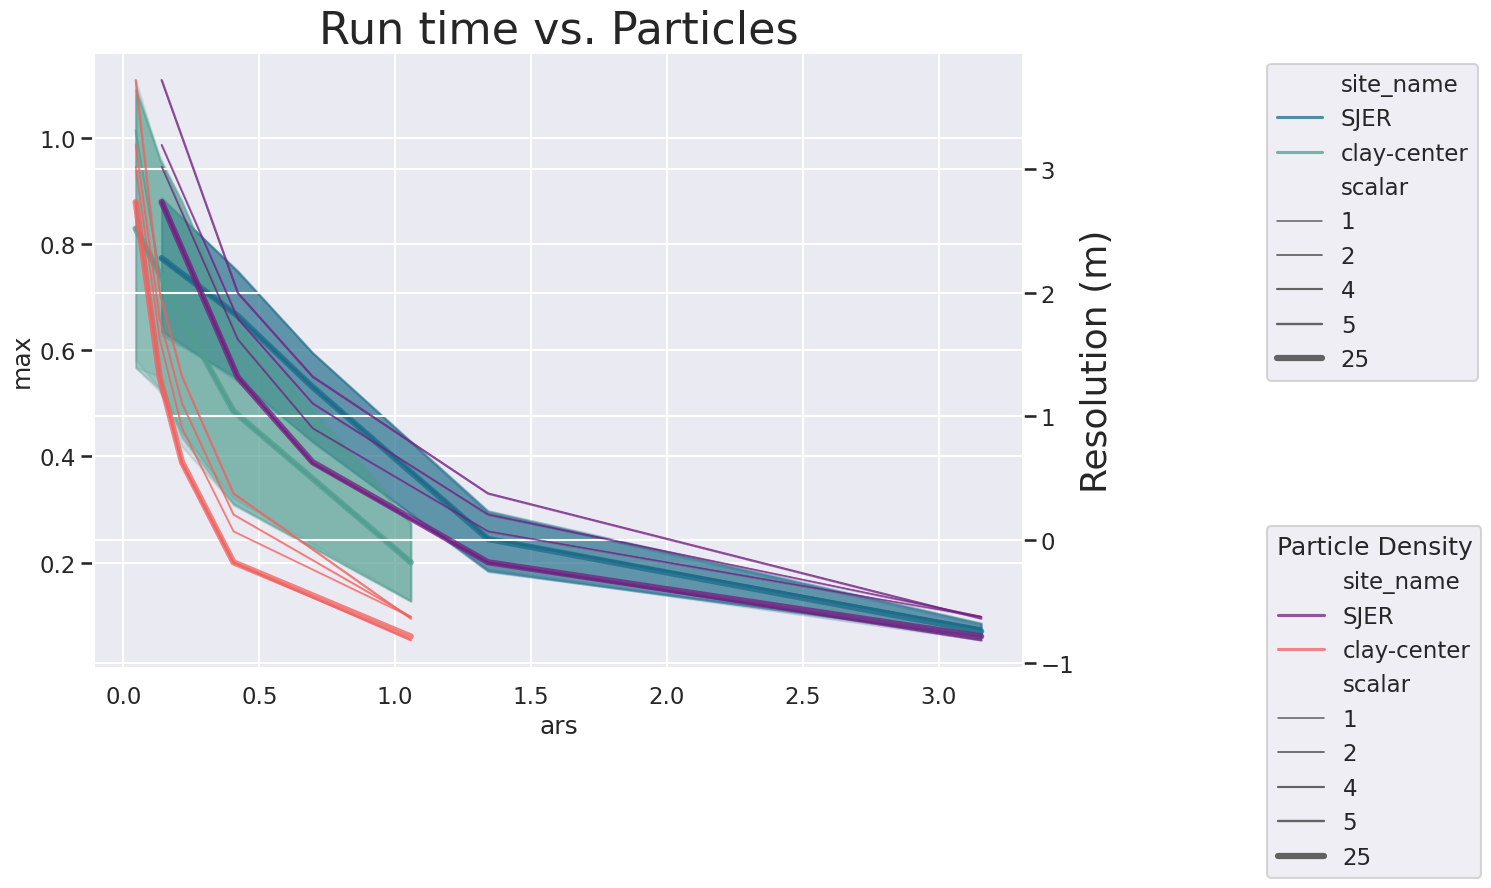

In [263]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average'"),
    # x="p_density",
    x="ars",
    y="max",
    # y="run_time_min",
    hue="site_name",
    size="scalar",
    palette="crest_r",
    markers=True,
    # style='resolution',
    alpha=0.75,
    errorbar=('ci', 95)
)



ax2 = plt.twinx()

sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average'"),
    # x="p_density",
    x="ars",
    y="log10(run_time)",
    # y="run_time_min",
    hue="site_name",
    size="scalar",
    palette="magma",
    markers=True,
    # style='resolution',
    alpha=0.75,
    errorbar=('ci', 95),
    ax=ax2
)
plt.xlabel("log10(Particles)", fontsize=26)
plt.ylabel("log10(Time (s))", fontsize=26)
plt.title("Run time vs. Particles", fontsize=32)
plt.legend(title="Particle Density", fontsize=18)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.25,1))
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1.25,0.25))
ax2.set_ylabel("Resolution (m)", fontsize=26)

# plt.savefig(os.path.join("../output", site, mapset, f'{site}_run_time_res_line_plot.png'))

# plt.savefig(f"../output/{site}/{mapset}/{site}_run_time_res_line_plot.png")
plt.show()

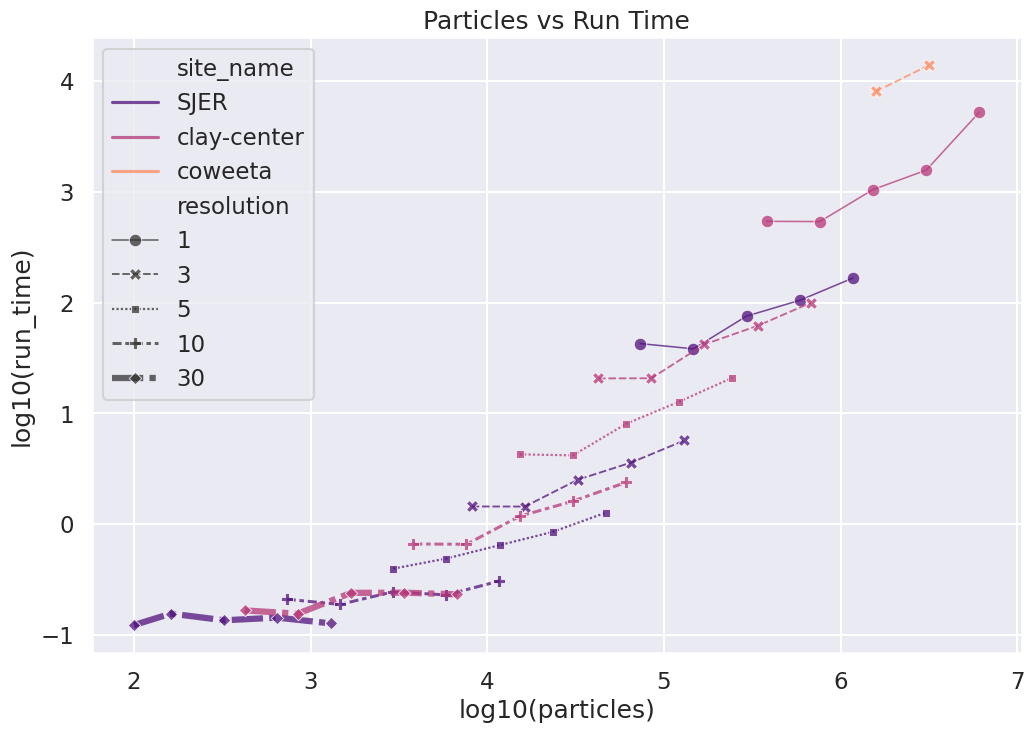

In [204]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df,
    x="log10(particles)",
    y="log10(run_time)",
    hue="site_name",
    size="resolution",
    style="resolution",
    # weights="error",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Particles vs Run Time")
plt.savefig(f"../output/agu2024_particles_run_time.png")


Text(0.5, 1.0, 'Particles vs Resolution')

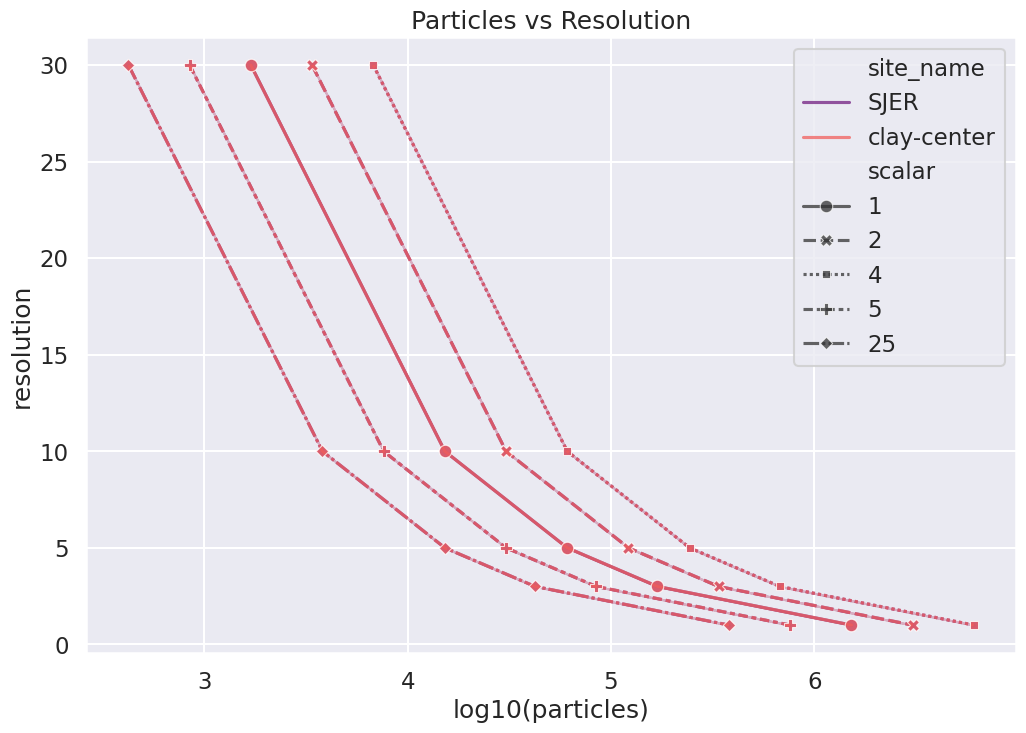

In [270]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df,
    x="log10(particles)",
    y="resolution",
    hue="site_name",
    style="scalar",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Particles vs Resolution")
# plt.savefig(f"../output/agu2024_particles_resolution.png")

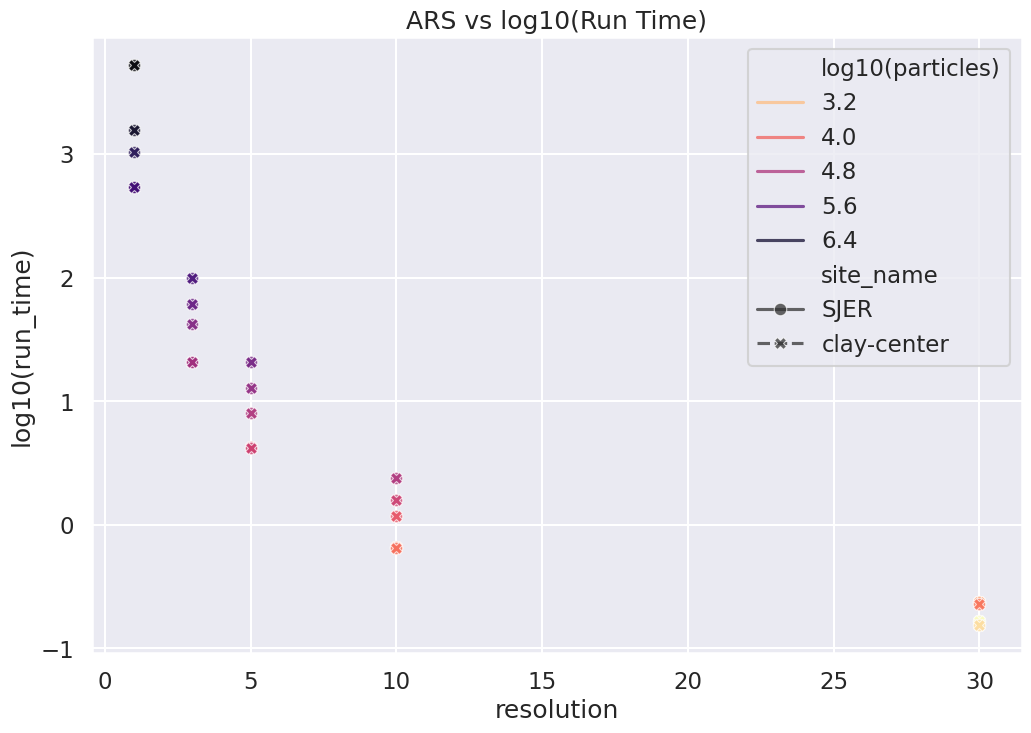

In [296]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average'"),
    x="resolution",
    y="log10(run_time)",
    hue="log10(particles)",
    style="site_name",
    # size="scalar",
    palette="magma_r",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("ARS vs log10(Run Time)")
plt.savefig(f"../output/agu2024_ars_run_time.png")

Text(0.5, 1.0, 'log10(particles) by Max Depth')

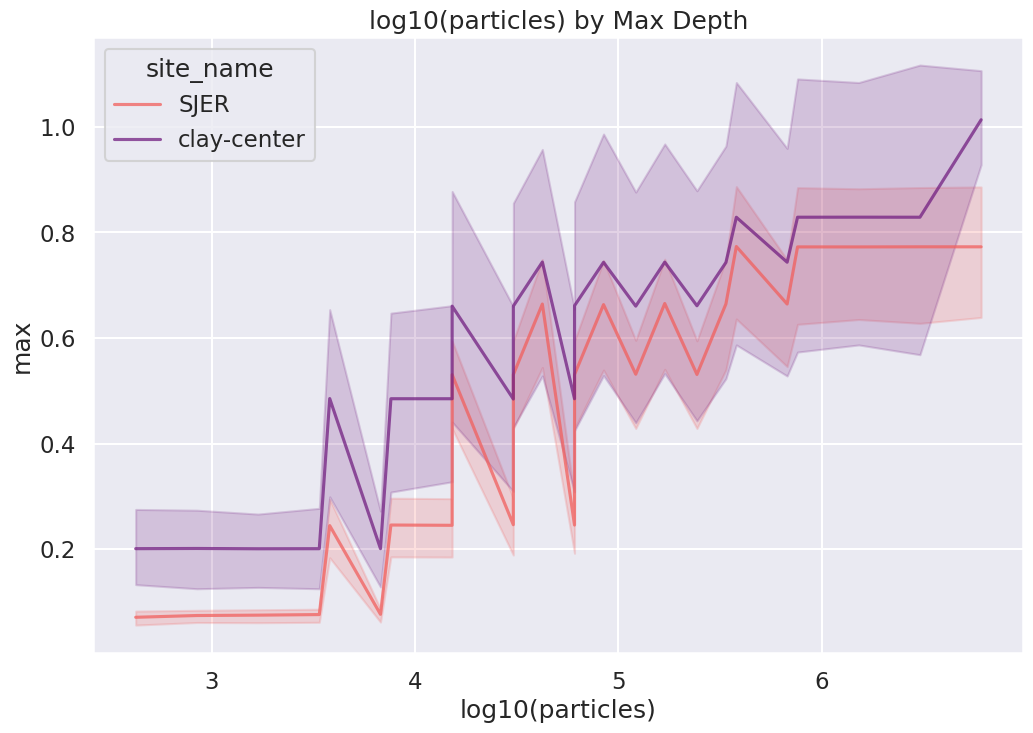

In [290]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average'"),
    x="log10(particles)",
    y="max",
    hue="site_name",
    # style="minute",
    palette="magma_r",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("log10(particles) by Max Depth")

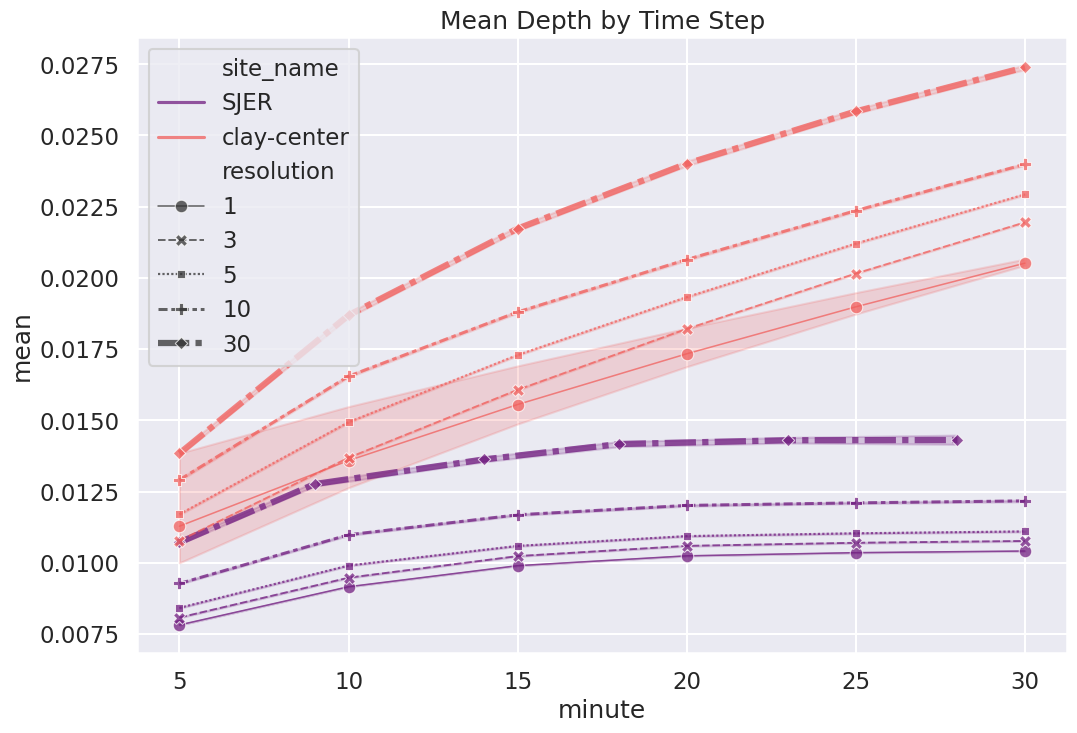

In [323]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'average'"),
    x=grouped_results_df.query("stat_type == 'average'")["minute"].astype(int),
    y="mean",
    hue="site_name",
    style="resolution",
    size="resolution",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Mean Depth by Time Step")
plt.savefig(f"../output/agu2024_minute_mean_resolution.png")

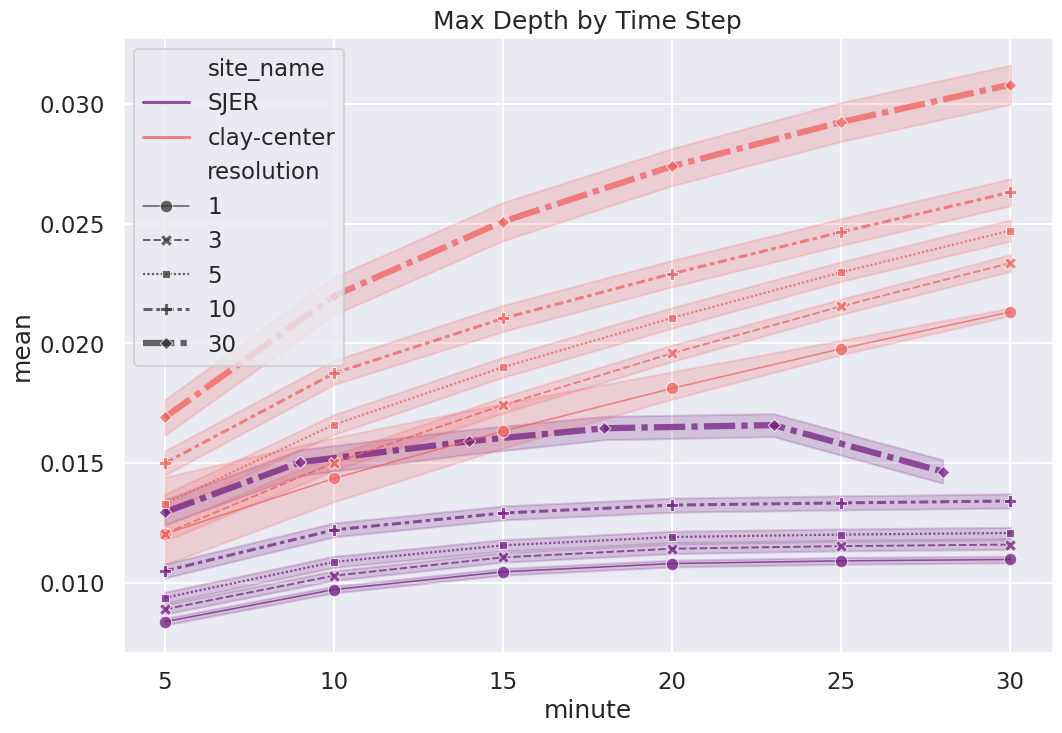

In [321]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'maximum'"),
    x=grouped_results_df.query("stat_type == 'maximum'")["minute"].astype(int),
    y="mean",
    hue="site_name",
    size="resolution",
    style="resolution",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Max Depth by Time Step")
plt.savefig(f"../output/agu2024_minute_max_resolution.png")

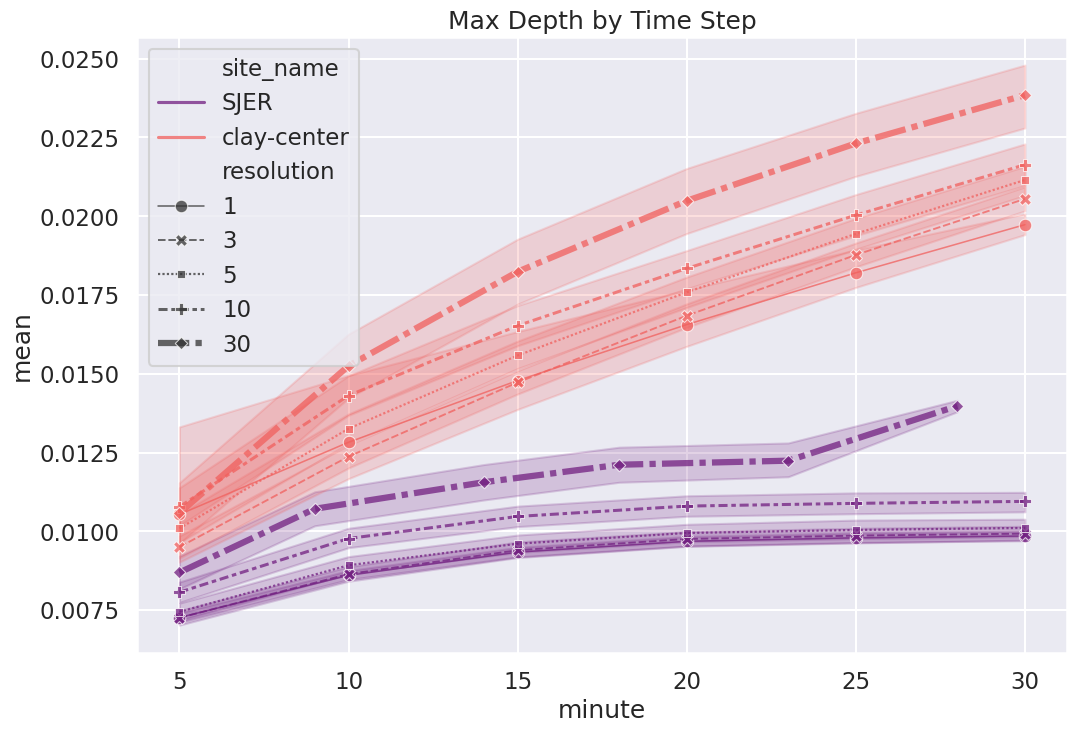

In [ ]:
sns.set_theme(style="darkgrid")
sns.set_context("talk")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(
    data=grouped_results_df.query("stat_type == 'minimum'"),
    x=grouped_results_df.query("stat_type == 'minimum'")["minute"].astype(int),
    y="mean",
    hue="site_name",
    style="resolution",
    size="resolution",
    palette="magma",
    markers=True,
    alpha=0.75,
    errorbar=('ci', 95),
)
plt.title("Min Depth by Time Step")
plt.savefig(f"../output/agu2024_minute_min_resolution.png")